In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [28]:
# Load the datasets
print("Loading datasets...")
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

print(f"Movies dataset shape: {movies.shape}")
print(f"Ratings dataset shape: {ratings.shape}")
print("\nFirst few rows of movies:")
print(movies.head())
print("\nFirst few rows of ratings:")
print(ratings.head())

Loading datasets...
Movies dataset shape: (62423, 3)
Ratings dataset shape: (25000095, 4)

First few rows of movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

First few rows of ratings:
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


In [29]:
# Basic data exploration
print("=== MOVIES DATASET INFO ===")
print(f"Total movies: {len(movies)}")
print(f"Unique genres: {movies['genres'].nunique()}")
print(f"Movies with missing genres: {movies['genres'].isnull().sum()}")

=== MOVIES DATASET INFO ===
Total movies: 62423
Unique genres: 1639
Movies with missing genres: 0


In [30]:
print("\n=== RATINGS DATASET INFO ===")
print(f"Total ratings: {len(ratings):,}")
print(f"Unique users: {ratings['userId'].nunique():,}")
print(f"Unique movies: {ratings['movieId'].nunique():,}")
print(f"Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")
print(f"Average rating: {ratings['rating'].mean():.2f}")


=== RATINGS DATASET INFO ===
Total ratings: 25,000,095
Unique users: 162,541
Unique movies: 59,047
Rating range: 0.5 - 5.0
Average rating: 3.53


## Visualizations

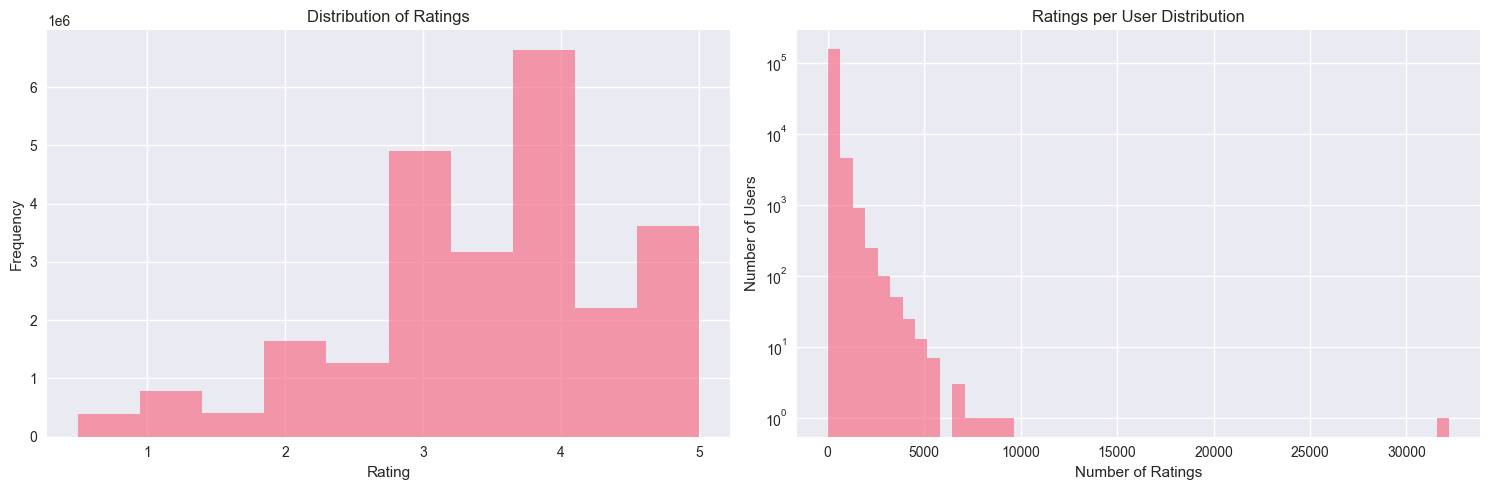

Users with most ratings: 32202
Users with least ratings: 20
Average ratings per user: 153.8


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Rating distribution
ratings['rating'].hist(bins=10, ax=axes[0], alpha=0.7)
axes[0].set_title('Distribution of Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')

# Ratings per user
user_rating_counts = ratings.groupby('userId').size()
axes[1].hist(user_rating_counts, bins=50, alpha=0.7)
axes[1].set_title('Ratings per User Distribution')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Users')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Users with most ratings: {user_rating_counts.max()}")
print(f"Users with least ratings: {user_rating_counts.min()}")
print(f"Average ratings per user: {user_rating_counts.mean():.1f}")


## Data Preprocessing

In [32]:

# More aggressive filtering to reduce memory usage
min_user_ratings = 100  
min_movie_ratings = 50 

# Count ratings per user and movie
user_ratings_count = ratings.groupby("userId").size()
movie_ratings_count = ratings.groupby("movieId").size()

# Filter users and movies
active_users = user_ratings_count[user_ratings_count >= min_user_ratings].index
popular_movies = movie_ratings_count[movie_ratings_count >= min_movie_ratings].index

ratings_filtered = ratings[ratings["userId"].isin(active_users) & ratings["movieId"].isin(popular_movies)]

print(f"Original ratings: {len(ratings):,}")
print(f"Filtered ratings: {len(ratings_filtered):,}")
print(f"Reduction: {((len(ratings) - len(ratings_filtered)) / len(ratings) * 100):.1f}%")

unique_users = ratings_filtered["userId"].nunique()
print(f"Unique users: {unique_users:,}")
unique_movies = ratings_filtered["movieId"].nunique()
print(f"Unique movies: {unique_movies:,}")

Original ratings: 25,000,095
Filtered ratings: 20,055,344
Reduction: 19.8%
Unique users: 63,892
Unique movies: 13,176


## Feature Engineering

In [33]:
all_genres = set()
for genres in movies["genres"].str.split("|"):
    all_genres.update(genres)
all_genres = sorted(list(all_genres))
print(f"Total unique genres: {len(all_genres)}")
print(f"Genres: {all_genres}")

# Create genre features for movies
genre_features = pd.DataFrame(0, index=movies.index, columns=all_genres)
for idx, genres in enumerate(movies["genres"].str.split("|")):
    for genre in genres:
        genre_features.loc[idx, genre] = 1
print(f"Genre features shape: {genre_features.shape}")

print("Genre distribution:")
genre_counts = genre_features.sum().sort_values(ascending=False)
for genre, count in genre_counts.head(10).items():
    print(f"  {genre}: {count} movies")

Total unique genres: 20
Genres: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Genre features shape: (62423, 20)
Genre distribution:
  Drama: 25606 movies
  Comedy: 16870 movies
  Thriller: 8654 movies
  Romance: 7719 movies
  Action: 7348 movies
  Horror: 5989 movies
  Documentary: 5605 movies
  Crime: 5319 movies
  (no genres listed): 5062 movies
  Adventure: 4145 movies


## Train/Test Split

In [34]:
from sklearn.model_selection import train_test_split

X_train_full, X_test_full = train_test_split(ratings_filtered, test_size=0.2, random_state=42)
print(f"Training set: {len(X_train_full):,}")
print(f"Test set: {len(X_test_full):,}")

print("Reducing dataset size for testing...")
subset_users = ratings_filtered["userId"].unique()[:200] 
subset_movies = ratings_filtered["movieId"].unique()[:300]  

ratings_subset = ratings_filtered[ratings_filtered["userId"].isin(subset_users) & ratings["movieId"].isin(subset_movies)]

rating_matrix = ratings_subset.pivot_table(
    index="userId", 
    columns="movieId", 
    values="rating",
    fill_value=0
 )


print(f"Subset rating matrix shape: {rating_matrix.shape}")
print(f"Subset sparsity: {(rating_matrix == 0).sum().sum() / (rating_matrix.shape[0] * rating_matrix.shape[1]) * 100:.2f}%")

X_train, X_test = train_test_split(ratings_subset, test_size=0.2, random_state=42)
print(f"Subset training set: {len(X_train):,}")
print(f"Subset test set: {len(X_test):,}")

Training set: 16,044,275
Test set: 4,011,069
Reducing dataset size for testing...
Subset rating matrix shape: (200, 300)
Subset sparsity: 80.42%
Subset training set: 9,399
Subset test set: 2,350


## Model Evaluation and Comparison

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, test_data, model_name):

    print(f"Evaluating {model_name}...")

    predictions = []
    actuals = []


    for user_id in test_data.index:
        for movie_id in test_data.columns:
            actual_rating = test_data.loc[user_id, movie_id]
            if actual_rating > 0:  # Only consider movies that were rated
                predicted_rating = model.predict(user_id, movie_id)
                predictions.append(predicted_rating)
                actuals.append(actual_rating)

    # Ensure there are valid predictions and actuals
    if len(predictions) == 0 or len(actuals) == 0:
        print(f"No valid predictions for {model_name}. Skipping evaluation.")
        return {"MSE": None, "RMSE": None, "MAE": None}


    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    print(f"{model_name} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

In [36]:
class UserBasedCF:
    def __init__(self, k=20):
        self.k = k
        self.user_similarity = None
        self.rating_matrix = None

    def fit(self, rating_matrix):
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np

        print("Computing user similarity matrix...")
        self.rating_matrix = rating_matrix
        self.user_similarity = cosine_similarity(rating_matrix)
        np.fill_diagonal(self.user_similarity, 0)  
        print("User similarity matrix computed.")

    def predict(self, user_id, movie_id):
        if self.user_similarity is None or self.rating_matrix is None:
            raise ValueError("Model has not been fitted yet.")

        user_index = self.rating_matrix.index.get_loc(user_id)
        movie_index = self.rating_matrix.columns.get_loc(movie_id)

        # Get similarity scores for the user
        user_similarities = self.user_similarity[user_index]
        user_ratings = self.rating_matrix.iloc[:, movie_index]

        # Compute weighted average of ratings
        numerator = (user_similarities * user_ratings).sum()
        denominator = user_similarities.sum()
        if denominator == 0:
            return 0  
        return numerator / denominator

# Initialize and fit user-based CF
print("Training User-based Collaborative Filtering...")
user_cf = UserBasedCF(k=10)  
user_cf.fit(rating_matrix)
print("User-based CF trained successfully!")

Training User-based Collaborative Filtering...
Computing user similarity matrix...
User similarity matrix computed.
User-based CF trained successfully!


In [37]:
# Matrix Factorization Implementation using SVD
import numpy as np
from sklearn.decomposition import TruncatedSVD

class SVDRecommender:
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.svd = TruncatedSVD(n_components=n_components, random_state=42)
        self.user_factors = None
        self.item_factors = None
        self.user_mean = None
        self.item_mean = None
        
    def fit(self, rating_matrix):
        """Fit SVD model"""
        print(f"Training SVD with {self.n_components} components...")
        
        self.user_mean = rating_matrix.mean(axis=1)
        centered_matrix = rating_matrix.sub(self.user_mean, axis=0)
        
        centered_matrix = centered_matrix.fillna(0)
        
        self.svd.fit(centered_matrix)
        
        # Get factor matrices
        self.user_factors = self.svd.transform(centered_matrix)
        self.item_factors = self.svd.components_.T
        
        print(f"Explained variance ratio: {self.svd.explained_variance_ratio_.sum():.3f}")
        print("SVD model trained successfully!")      

    def predict(self, user_id, movie_id):
        """Predict rating for a user-movie pair"""
        if user_id not in rating_matrix.index or movie_id not in rating_matrix.columns:
            return 0
            
        user_idx = rating_matrix.index.get_loc(user_id)
        movie_idx = rating_matrix.columns.get_loc(movie_id)
        
        # Predict using factor matrices
        prediction = np.dot(self.user_factors[user_idx], self.item_factors[movie_idx])
        
        prediction += self.user_mean[user_id]
        
        return max(0.5, min(5.0, prediction))


# Initialize and fit SVD 
print("Training SVD Matrix Factorization...")
svd_model = SVDRecommender(n_components=20) 
svd_model.fit(rating_matrix)
print("SVD model trained successfully!")

Training SVD Matrix Factorization...
Training SVD with 20 components...
Explained variance ratio: 0.500
SVD model trained successfully!
SVD model trained successfully!


In [38]:
# Create models dictionary
models = {
    'User-based CF': user_cf,
    'SVD': svd_model
}

# Create test pivot table from X_test ratings
X_test_pivot = X_test.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating',
    fill_value=0
)

print(f"Test data shape: {X_test_pivot.shape}")
print(f"Non-zero ratings in test data: {(X_test_pivot > 0).sum().sum()}")


results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_test_pivot, name)
    print(f"{name} evaluation completed.")
results

Test data shape: (199, 278)
Non-zero ratings in test data: 2350
Evaluating User-based CF...
User-based CF - MSE: 6.537223022534551, RMSE: 2.5567993708022048, MAE: 2.330158623639003
User-based CF evaluation completed.
Evaluating SVD...
SVD - MSE: 2.7830582691031567, RMSE: 1.6682500619221199, MAE: 1.3575174400849679
SVD evaluation completed.


{'User-based CF': {'MSE': 6.537223022534551,
  'RMSE': np.float64(2.5567993708022048),
  'MAE': 2.330158623639003},
 'SVD': {'MSE': 2.7830582691031567,
  'RMSE': np.float64(1.6682500619221199),
  'MAE': 1.3575174400849679}}

Model Performance Comparison:
                 MSE   RMSE    MAE
User-based CF  6.537  2.557  2.330
SVD            2.783  1.668  1.358


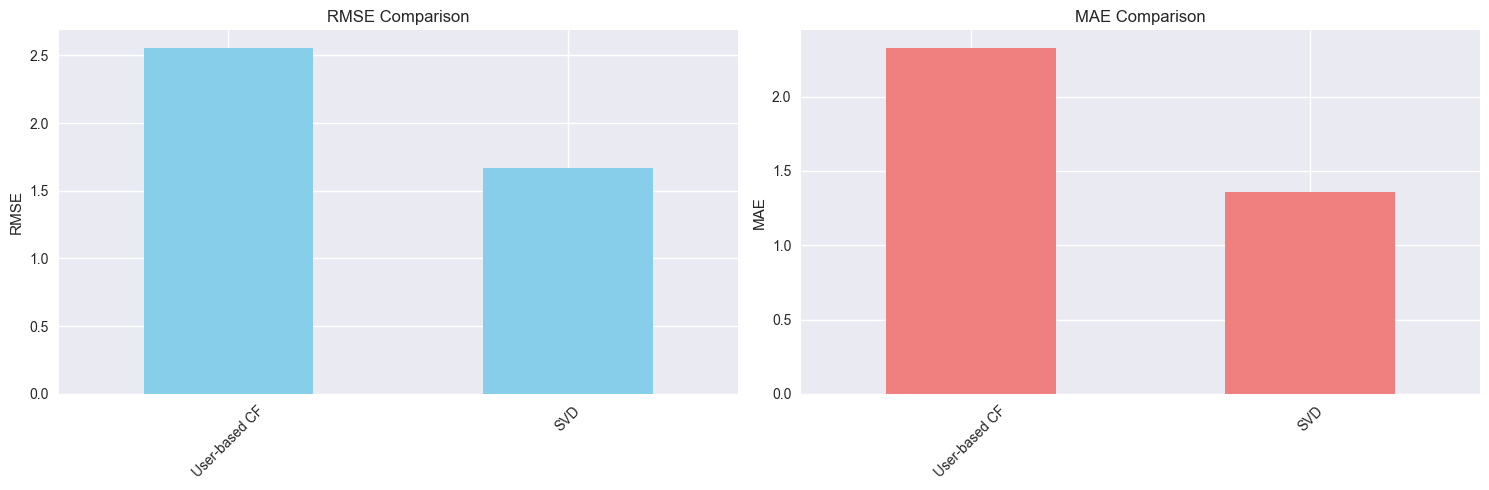

In [39]:
# Visualize model comparison
results_df = pd.DataFrame(results).T


print("Model Performance Comparison:")
print(results_df.round(3))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RMSE comparison - Plots a bar chart of RMSE values
results_df['RMSE'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison - Plots a bar chart of MAE values
results_df['MAE'].plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Recommendation Functions and Demo


In [40]:
# Recommendation Functions
def get_top_recommendations(model, user_id, n_recommendations=10):
    """Get top N movie recommendations for a user"""
    all_movies = rating_matrix.columns
    
    # Get movies already rated by the user
    user_ratings = rating_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index
    
    # Find unrated movies
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]
    
    # Predict ratings for unrated movies
    predictions = []
    for movie_id in unrated_movies:
        pred = model.predict(user_id, movie_id)
        predictions.append((movie_id, pred))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    return predictions[:n_recommendations]

def display_recommendations(recommendations, movies, user_id, model_name):
    """Display recommendations in a formatted way"""
    print(f"\n=== Top Recommendations for User {user_id} using {model_name} ===")
    print("-" * 80)
    
    for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
        movie_info = movies[movies['movieId'] == movie_id]
        if not movie_info.empty:
            title = movie_info.iloc[0]['title']
            genres = movie_info.iloc[0]['genres']
            print(f"{i}. {title}")
            print(f"    Movie ID: {movie_id} | Predicted Rating: {pred_rating:.2f}")
            print(f"    Genres: {genres}")
            print()

In [41]:
def recommend_movies_interactive(user_id, model_name='SVD'):
    """Interactive function to get recommendations for any user"""
    
    if user_id not in rating_matrix.index:
        print(f"User {user_id} not found in the dataset")
        print(f"Available users: {rating_matrix.index.min()} to {rating_matrix.index.max()}")
        return
    
    # Define models
    models_for_demo = {
        'User-based CF': user_cf,
        'SVD': svd_model
    }
    
    if model_name not in models_for_demo:
        print(f"Model '{model_name}' not available. Using default 'SVD'.")
        model_name = 'SVD'
    
    model = models_for_demo[model_name]
    
    print(f"\nGetting recommendations for User {user_id} using {model_name}...")
    
    # Show user's current ratings
    user_ratings = rating_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0]
    
    print(f"\nUser {user_id} has rated {len(rated_movies)} movies:")
    print("Recent ratings:")
    for movie_id, rating in rated_movies.tail(5).items():
        movie_info = movies[movies['movieId'] == movie_id]
        if not movie_info.empty:
            title = movie_info.iloc[0]['title']
            print(f"  {title}: {rating}")
    
    # Get recommendations
    recommendations = get_top_recommendations(model, user_id, n_recommendations=10)
    display_recommendations(recommendations, movies, user_id, model_name)
    
    return recommendations

In [42]:
# Recommendation Functions and Demo
recommendations = recommend_movies_interactive(3, 'User-based CF')


Getting recommendations for User 3 using User-based CF...

User 3 has rated 175 movies:
Recent ratings:
  Star Wars: Episode III - Revenge of the Sith (2005): 4.0
  Batman Begins (2005): 4.0
  Wedding Crashers (2005): 3.0
  40-Year-Old Virgin, The (2005): 3.0
  Harry Potter and the Goblet of Fire (2005): 4.0

=== Top Recommendations for User 3 using User-based CF ===
--------------------------------------------------------------------------------
1. Sixth Sense, The (1999)
    Movie ID: 2762 | Predicted Rating: 2.56
    Genres: Drama|Horror|Mystery

2. Saving Private Ryan (1998)
    Movie ID: 2028 | Predicted Rating: 2.33
    Genres: Action|Drama|War

3. Braveheart (1995)
    Movie ID: 110 | Predicted Rating: 2.30
    Genres: Action|Drama|War

4. Monty Python and the Holy Grail (1975)
    Movie ID: 1136 | Predicted Rating: 2.03
    Genres: Adventure|Comedy|Fantasy

5. Indiana Jones and the Last Crusade (1989)
    Movie ID: 1291 | Predicted Rating: 1.94
    Genres: Action|Adventure

6.